In [78]:
import modin.pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
train_df = pd.read_parquet('/home/alex/Projects/DataSci/ML/Kaggle/StoreSales/Datalake/train.parquet')
transactions_df = pd.read_parquet('/home/alex/Projects/DataSci/ML/Kaggle/StoreSales/Datalake/transactions.parquet')

In [46]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [47]:
print(train_df['date'].min())
print(train_df['date'].max())

2013-01-01
2017-08-15


In [94]:
#get only sales from train_df in where family is  LIQUOR,WINE,BEER
train_alcohol = train_df[train_df['family'].isin(['LIQUOR,WINE,BEER'])]
print(train_alcohol['family'].unique())

['LIQUOR,WINE,BEER']


In [96]:
#convert date to datetime
train_alcohol['date'] = pd.to_datetime(train_alcohol['date'])

In [97]:
train_alcohol['year'] = train_alcohol['date'].dt.year
train_alcohol['month'] = train_alcohol['date'].dt.month

In [98]:
train_alcohol['date'] = pd.to_numeric(train_alcohol['date'])
train_alcohol['year'] = pd.to_numeric(train_alcohol['year'])
train_alcohol['month'] = pd.to_numeric(train_alcohol['month'])

In [100]:
#column types of train_alcohol
train_alcohol.dtypes

id               int64
date             int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
year             int32
month            int32
dtype: object

<Axes: xlabel='year', ylabel='sales'>

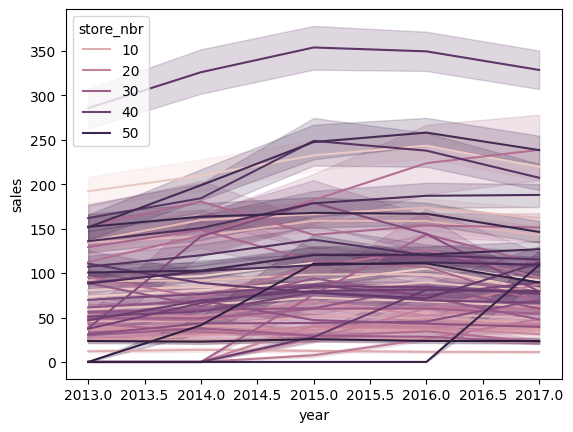

In [101]:
#plot sales of train_alcohol
sns.lineplot(data=train_alcohol, x='year', y='sales', hue='store_nbr', markers=True)

In [106]:
#get the sum of sales per store per year
train_alcohol_2014 = train_alcohol[train_alcohol['year']== 2014]
train_alcohol_sales_2014 = train_alcohol_2014.groupby(['store_nbr'])['sales'].sum()


In [109]:
train_alcohol_sales_2014.describe().transpose()

count        54.000000
mean      28736.574074
std       23845.164804
min           0.000000
25%       12789.500000
50%       23176.000000
75%       37355.250000
max      118734.000000
Name: sales, dtype: float64